In [1]:
from esda.moran import Moran
import geopandas as gpd
import json
import numpy as np
import pandas as pd
from libpysal.weights import DistanceBand, KNN
import matplotlib
import matplotlib.pyplot as plt
from splot.esda import plot_moran
import spreg

from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")
gdf = gdf.sample(frac=.025)

In [4]:
print(gdf["Town Code"].value_counts())

72    1061
71     833
77     526
70     466
37     377
31     344
39     286
38     273
22     242
13     239
18     219
73     217
21     213
35     205
32     205
12     202
29     195
24     181
20     179
25     175
28     159
23     157
16     136
15     121
11     116
27     116
76     103
30      79
17      78
75      69
36      67
74      54
26      47
10      45
34      41
19      31
33      25
14      25
Name: Town Code, dtype: int64


In [5]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
162431,-0.230501,-1.481514,-1.003848,-0.942160,-1.375960,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.621503,-0.795788,-0.732717,-0.282422,25172190600000,321,72,POINT (446152.574 4616887.255)
223652,-0.294189,-0.292681,-0.480130,0.181142,0.270420,-0.599533,-0.891279,0.550000,-0.041762,1.066654,0.503276,-0.268846,-0.607519,0.222796,10172200020000,31,24,POINT (436226.185 4655776.305)
116834,-0.230501,0.550809,0.293660,0.945375,0.511311,1.422378,0.635637,-2.100215,-0.041762,1.066654,0.510367,0.176677,1.145252,0.099542,10151020370000,51,24,POINT (438793.001 4656072.548)
256891,-0.294189,-0.292681,-0.720572,-1.936923,-0.801719,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,0.461116,-0.795788,0.143668,-2.757526,30203050470000,101,37,POINT (455761.682 4604647.846)
68397,-1.790873,-0.292681,0.758195,0.896305,-0.977047,1.422378,0.635637,0.550000,-0.041762,1.066654,-1.395462,0.176677,-1.734301,0.673466,4151000630000,160,25,POINT (431655.867 4663568.254)


In [6]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

In [7]:
w.transform = 'R'

In [8]:
rsem = spreg.ML_Error_Regimes(y, X, w=w,
                            regimes=list(gdf["Town Code"]),
                            name_x=i_vars, name_y="Sale Price", regime_lag_sep=False, cols2regi=[False]*len(i_vars))

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [9]:
print(rsem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR - REGIMES (METHOD = full)
-----------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :     -0.0276                Number of Variables   :          51
S.D. dependent var  :      1.0147                Degrees of Freedom    :        8056
Pseudo R-squared    :      0.5344
Sigma-square ML     :       0.302                Log likelihood        :   -5953.284
S.E of regression   :       0.549                Akaike info criterion :   12008.568
                                                 Schwarz criterion     :   12365.592

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------

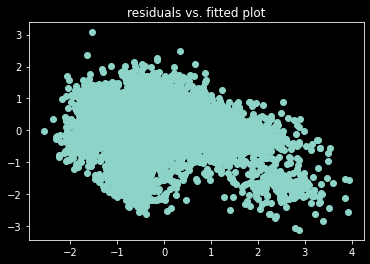

In [10]:
plt.scatter(rsem.predy, rsem.u)
plt.title("residuals vs. fitted plot")
plt.show()

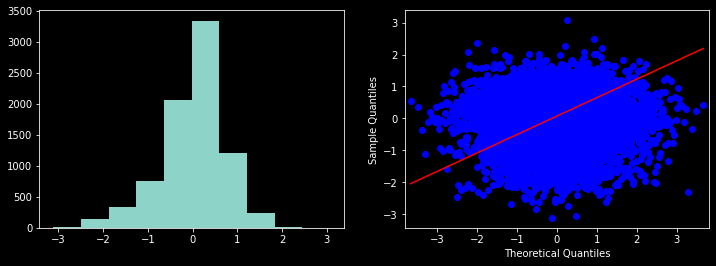

In [11]:
q_q_plot(rsem.u)

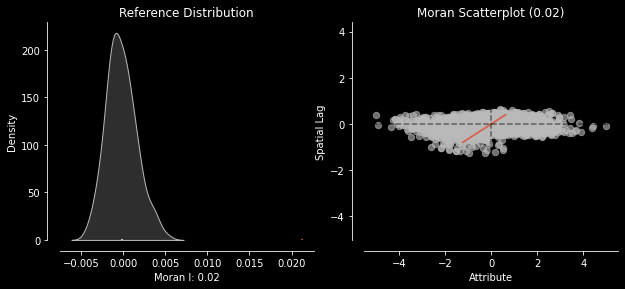

In [12]:
rsem_moran = Moran(rsem.e_filtered, w, permutations=199)
plot_moran(rsem_moran, zstandard=True, figsize=(10,4))
plt.show()

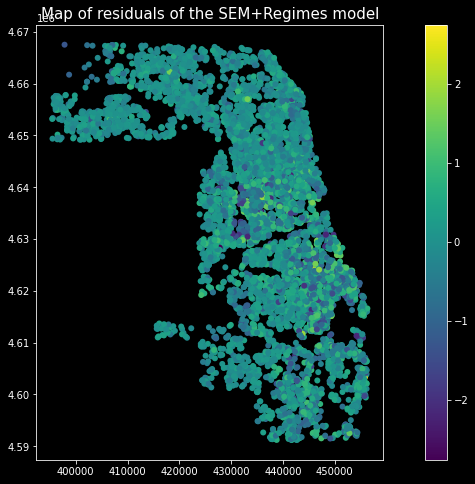

In [13]:
ax = gdf.plot(column=rsem.e_filtered.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SEM+Regimes model",fontsize=15)
plt.show()

In [14]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ rsem.betas[town_codes.index(code), 0] for code in gdf_town_codes ]
gdf["SEMRegimeBeta"] = regime_betas

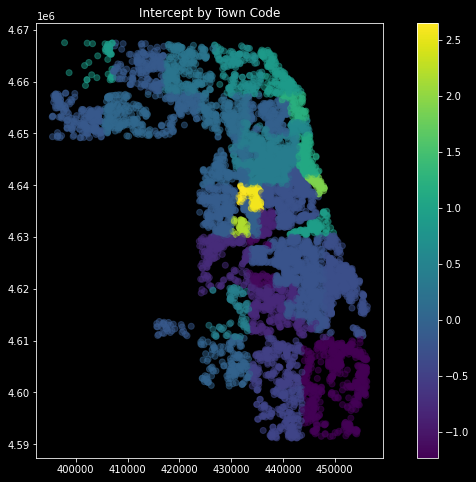

In [15]:
cmap=matplotlib.cm.viridis
norm=matplotlib.colors.Normalize(vmin=min(gdf["SEMRegimeBeta"]), vmax=max(gdf["SEMRegimeBeta"]))
ax = gdf.plot(column="SEMRegimeBeta", legend=True, figsize=(12,8), alpha=0.5, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()

In [16]:
# trying to get it so we can plot based on town code beta
town_codes = sorted(list(set(gdf["Town Code"])))
gdf_town_codes = list(gdf["Town Code"])
regime_betas = [ float(rsem.betas[town_codes.index(code), 0]) if rsem.z_stat[town_codes.index(code)][1] < 0.05 else float('inf') for code in gdf_town_codes ]
gdf["SEMRegimeBetaIfSig"] = regime_betas

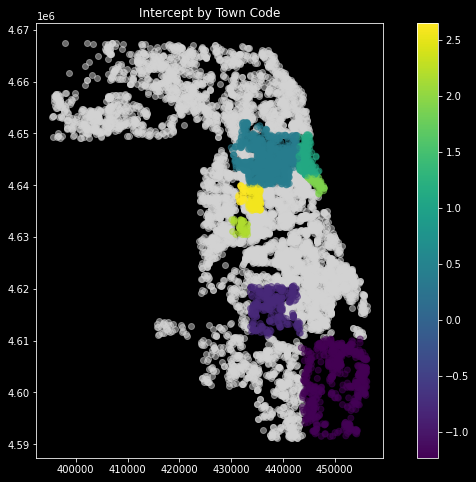

In [17]:
has_data = gdf[gdf["SEMRegimeBetaIfSig"] != float('inf')]
no_data = gdf[gdf["SEMRegimeBetaIfSig"] == float('inf')]
ax = no_data.plot(color='lightgrey', alpha=0.5, figsize=(12,8))
ax = has_data.plot(column="SEMRegimeBetaIfSig", categorical=False, legend=True, alpha=0.5, ax=ax, cmap=cmap, norm=norm)
plt.title("Intercept by Town Code")
plt.show()